In [44]:
import nest_asyncio
nest_asyncio.apply()

from hddCRP.modelBuilder import cdCRP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statannotations.Annotator import Annotator

import os

In [45]:
session_numbers = [1]; # index by 1

overwrite_existing_results = False
results_directory = "Results/population/"

if(not os.path.exists(results_directory)):
    os.makedirs(results_directory)

data_filename = 'data/Data_turns_all_by_session.pkl';
with open(data_filename, 'rb') as data_file:
    data = pickle.load(data_file)

subjects = ["uniform", "diverse"]
subjects.sort()
print("subjects = " + str(subjects))

context_depth = 2;
nback_depth = 0;

action_labels = [0,1,2]

subjects = ['diverse', 'uniform']


In [46]:
start_session = np.min(session_numbers)
end_session = np.max(session_numbers)
fit_file = f"{results_directory}/fits_session_{start_session}"
fit_summary_file = f"{results_directory}/fit_summary_session_{start_session}"
if(end_session != start_session):
    fit_file += f"_to_{start_session}"
    fit_summary_file  += f"_to_{start_session}"

if(nback_depth != 1 or context_depth != 2):
    fit_file += f"_cd{context_depth}_nb{nback_depth}"
    fit_summary_file  += f"_cd{context_depth}_nb{nback_depth}"

fit_file += f".pkl"
fit_summary_file += f".pkl"

if(not os.path.isfile(fit_file) or overwrite_existing_results):
    data_fits = pd.DataFrame()
    data_fit_metrics = pd.DataFrame()
    for subject_index, subject in enumerate(subjects):
        print(f"subject {subject} ")

        sequences = []
        session_types = []
        subject_labels = []
        for subject_p in data["group_definition"][subject]:
            sequences_0 = data["data"][subject_p]["data"]; # turns in each session
            session_types_0 = data["data"][subject_p]["task"] # which maze
            ii = list(np.where(np.array(session_types_0)=='C')[0][np.array(session_numbers)-1])
            sequences     += [sequences_0[xx] for xx in ii]
            session_types += [session_types_0[xx] for xx in ii]
            subject_labels += [subject_p] * len(ii)

        stan_seed = (subject_index+1) * 1000 + start_session

        model = cdCRP(sequences, session_labels=session_types, subject_labels=subject_labels, possible_observations=action_labels);
        model.same_nback_depth = nback_depth
        model.context_depth = context_depth

        model.build(random_seed=stan_seed);
        model.fit_model()

        map_fit = model.get_map()
        fit_df = model.fit.to_frame()
        fit_df["subject"] = subject
        fit_df["start_session_C"] = start_session
        fit_df["end_session_C"] = end_session
        summary_df = model.fit_summary()
        summary_df["subject"] = subject
        summary_df["MAP"] = pd.Series(map_fit)
        summary_df["start_session_C"] = start_session
        summary_df["end_session_C"] = end_session

        data_fit_metrics = pd.concat([data_fit_metrics,summary_df], copy=False)
        data_fits = pd.concat([data_fits,fit_df], copy=False)

    data_fits.to_pickle(fit_file)
    data_fit_metrics.to_pickle(fit_summary_file)
else:
    print("fit file found")



subject diverse 
Building...

In file included from /home/latimerk/miniconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/boost/multi_array/multi_array_ref.hpp:32,
                 from /home/latimerk/miniconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/boost/multi_array.hpp:34,
                 from /home/latimerk/miniconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/boost/numeric/odeint/algebra/multi_array_algebra.hpp:22,
                 from /home/latimerk/miniconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/boost/numeric/odeint.hpp:63,
                 from /home/latimerk/miniconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/prim/functor/ode_rk45.hpp:9,
                 from /home/latimerk/miniconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6,
                 from /home/latimerk/miniconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/st


Building: 51.7s, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)

In [ ]:
fit = pd.read_pickle(fit_file)
summary_fit = pd.read_pickle(fit_summary_file)
params = np.unique(summary_fit.index)


array(['alpha', 'context_similarity_depth_1',
       'context_similarity_depth_2', 'repeat_bias_1_back',
       'timeconstant_within_session_C'], dtype=object)

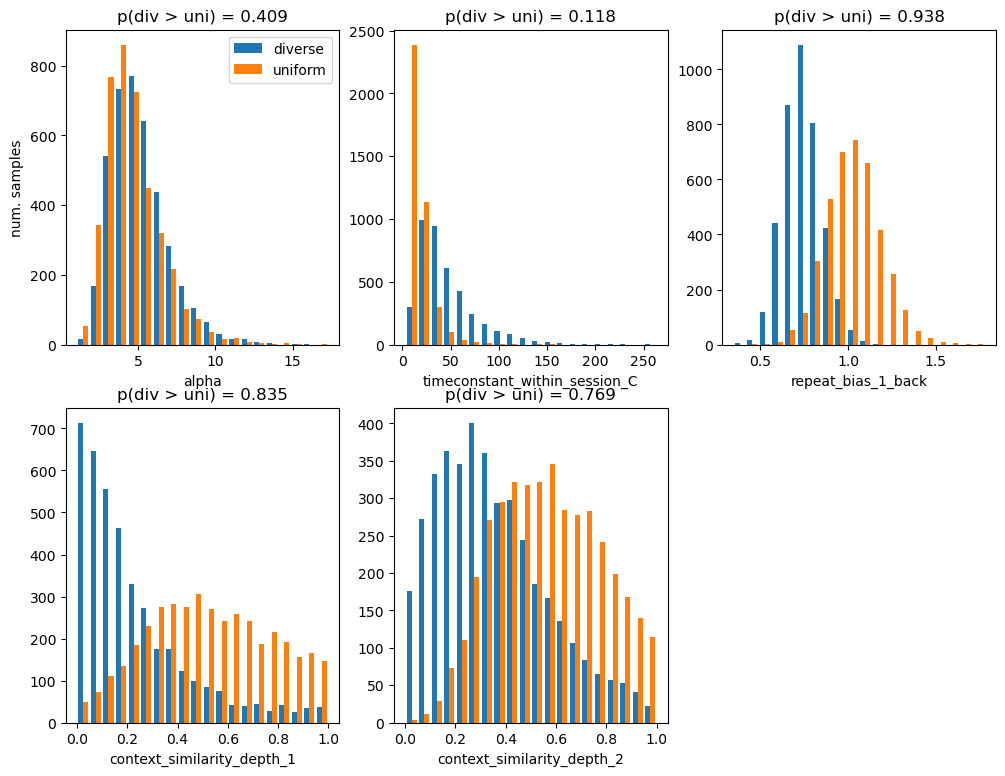

In [ ]:
pval_seed = 10;
sim_rng = np.random.Generator(np.random.MT19937(pval_seed))

plt.figure(figsize=(3*4, 3*3))
for ii in range(len(params)):
    ax = plt.subplot(2,3,ii+1);
    #fit.hist(params[ii], by="subject", ax=ax);
    pp =  fit.pivot(columns=["subject"],values=[params[ii]]).droplevel(0,axis=1);
    plt.hist(pp.to_numpy(),20)
    plt.xlabel(params[ii])

    aa = pp["diverse"].sample(replace=False,frac=1,random_state=sim_rng).reset_index()
    bb = pp["uniform"].sample(replace=False,frac=1,random_state=sim_rng).reset_index()

    pval = (bb["uniform"]>aa["diverse"]).mean()

    plt.title(f"p(div > uni) = {pval:.3f}")
    if(ii == 0):
        plt.ylabel('num. samples')
        plt.legend(subjects)
   

0.40775